In [100]:
import os
import re
import glob
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import arabic_reshaper
from bidi.algorithm import get_display


from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
# دالة دعم العربية
def ar(text):
    return get_display(arabic_reshaper.reshape(text))

import matplotlib.dates as mdates


In [101]:
#  إعدادات الخط 
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False

In [102]:
DATA_DIR = "SWX_DRAP20_C_SWPC_20250514"
FILE_GLOB = os.path.join(DATA_DIR, "*_GLOBAL.txt")

ARAB_LAT_MIN, ARAB_LAT_MAX = 0.0, 40.0
ARAB_LON_MIN, ARAB_LON_MAX = -20.0, 60.0

#THRESHOLDS_DB = [0.5, 1.0, 2.0]
THRESHOLDS_DB = [1.0, 3.0, 10.0]

GOES_XRAYS_1DAY_URL = (
    "https://services.swpc.noaa.gov/json/goes/primary/xrays-1-day.json"
)
GOES_LONG_CHANNEL = "0.1-0.8nm"



In [103]:
#   DRAP
def parse_drap_txt(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.read().splitlines()

    valid_time = None
    for ln in lines[:80]:
        if "Product Valid At" in ln:
            m = re.search(
                r"(\d{4}-\d{2}-\d{2})\s+(\d{2}:\d{2})", ln
            )
            if m:
                valid_time = dt.datetime.strptime(
                    f"{m.group(1)} {m.group(2)}", "%Y-%m-%d %H:%M"
                ).replace(tzinfo=dt.timezone.utc)

    if valid_time is None:
        raise ValueError("لم يتم العثور على وقت الصلاحية")

    lon_idx = None
    for i, ln in enumerate(lines):
        if re.match(r"^\s*-?\d+\s+-?\d+", ln) and len(ln.split()) > 20:
            lon_idx = i
            break

    lons = np.array(lines[lon_idx].split(), float)

    data_start = None
    for i in range(lon_idx + 1, len(lines)):
        if re.match(r"^\s*-?\d+\s*\|", lines[i]):
            data_start = i
            break

    lats, grid = [], []
    for ln in lines[data_start:]:
        if not re.match(r"^\s*-?\d+\s*\|", ln):
            continue
        lat, vals = ln.split("|", 1)
        lats.append(float(lat))
        grid.append([float(v) for v in vals.split()])

    lats = np.array(lats)
    grid = np.array(grid)

    order = np.argsort(lats)
    return valid_time, lats[order], lons, grid[order]


def subset_region(lats, lons, grid):
    lat_mask = (lats >= ARAB_LAT_MIN) & (lats <= ARAB_LAT_MAX)
    lon_mask = (lons >= ARAB_LON_MIN) & (lons <= ARAB_LON_MAX)
    return grid[np.ix_(lat_mask, lon_mask)]




#  قراءة جميع الملفات
files = sorted(glob.glob(FILE_GLOB))
records = {}
series = []

for f in files:
    t, lats, lons, grid = parse_drap_txt(f)
    agrid = subset_region(lats, lons, grid)

    series.append({
        "time": t,
        "mean": np.nanmean(agrid),
        "max": np.nanmax(agrid)
    })
    records[t] = (lats, lons, grid)

df = pd.DataFrame(series).sort_values("time").reset_index(drop=True)





#  خرائط قبل / ذروة / بعد
peak_time = df.loc[df["mean"].idxmax(), "time"]
pre_time  = df.iloc[0]["time"]
post_time = df.iloc[-1]["time"]




def plot_map(lats, lons, grid, title, arab_box=True):
    proj = ccrs.PlateCarree()

    fig = plt.figure(figsize=(10,5))
    ax = plt.axes(projection=proj)

    Lon, Lat = np.meshgrid(lons, lats)

    im = ax.pcolormesh(
        Lon, Lat, grid,
        transform=proj,
        shading="auto"
    )

    #  
    ax.coastlines(resolution="110m", linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    #  المنطقة العربية
    if arab_box:
        ax.plot(
            [ARAB_LON_MIN, ARAB_LON_MAX, ARAB_LON_MAX, ARAB_LON_MIN, ARAB_LON_MIN],
            [ARAB_LAT_MIN, ARAB_LAT_MIN, ARAB_LAT_MAX, ARAB_LAT_MAX, ARAB_LAT_MIN],
            transform=proj,
            color="black",
            linewidth=2,
            label=ar("المنطقة العربية")
        )

    ax.set_title(ar(title))
    ax.set_xlabel(ar("خط الطول"))
    ax.set_ylabel(ar("خط العرض"))

    cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.02)
    #cbar.set_label(ar("الامتصاص الراديوي (dB)"))
    cbar.set_label(ar(" freq. MHz"))

    plt.tight_layout()
    plt.show()




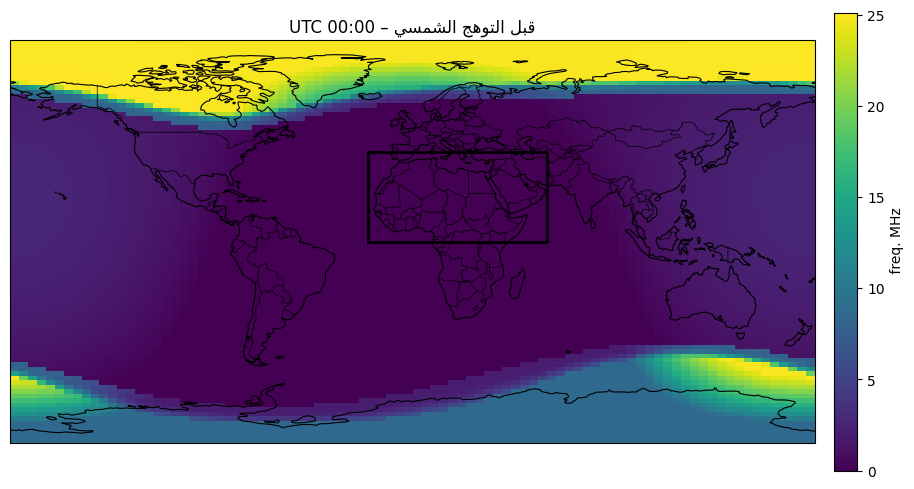

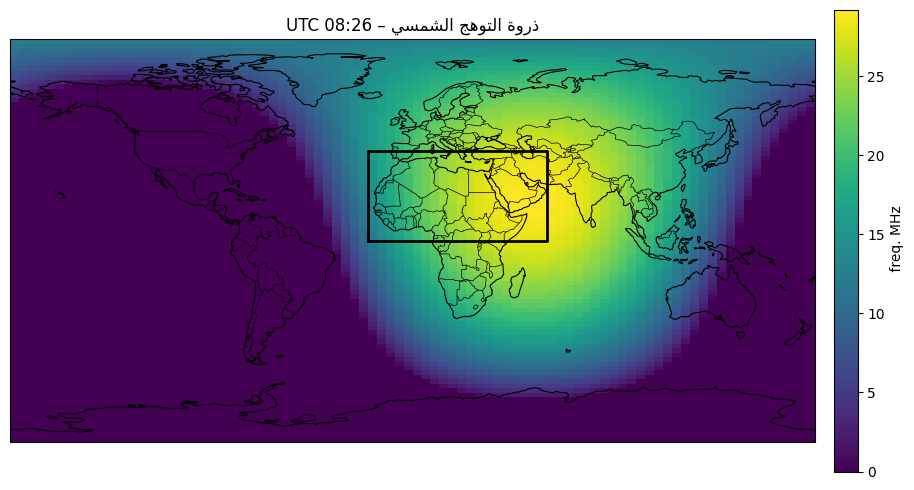

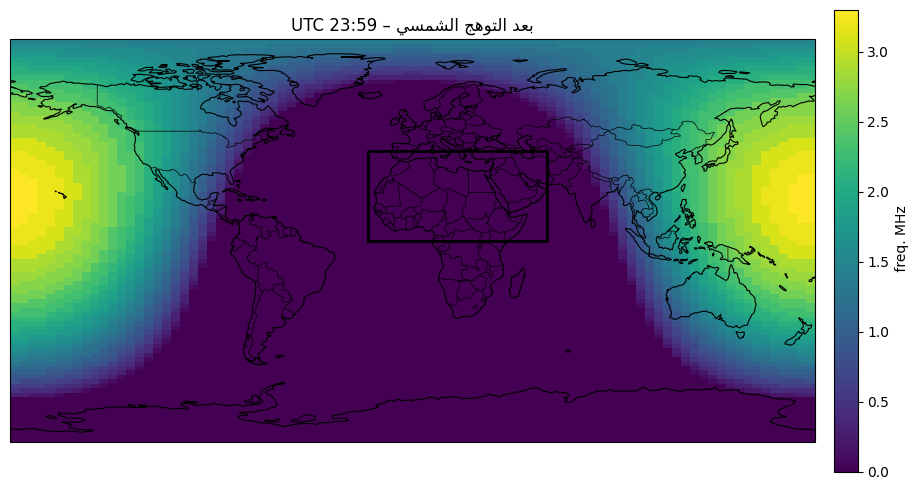

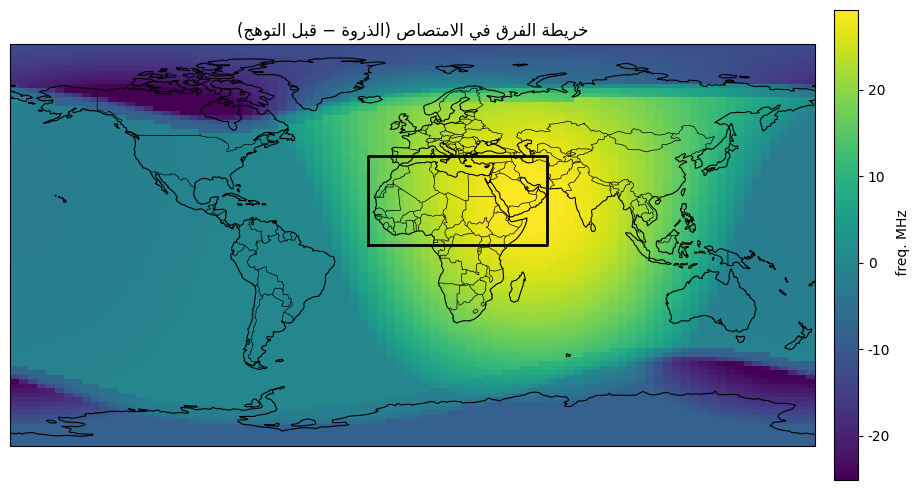

In [104]:
plot_map(*records[pre_time],
         f"قبل التوهج الشمسي – {pre_time.strftime('%H:%M UTC')}")

plot_map(*records[peak_time],
         f"ذروة التوهج الشمسي – {peak_time.strftime('%H:%M UTC')}")

plot_map(*records[post_time],
         f"بعد التوهج الشمسي – {post_time.strftime('%H:%M UTC')}")


#  خريطة الفرق (ذروة – قبل)
lats, lons, g_pre  = records[pre_time]
_,    _,    g_peak = records[peak_time]

diff = g_peak - g_pre

plot_map(
    lats, lons, diff,
    "خريطة الفرق في الامتصاص (الذروة − قبل التوهج)"
)


In [105]:
files = sorted(glob.glob(FILE_GLOB))
records = {}
series = []

for f in files:
    t, lats, lons, grid = parse_drap_txt(f)
    agrid = subset_region(lats, lons, grid)

    series.append({
        "time": t,
        "mean": np.nanmean(agrid),
        "max": np.nanmax(agrid)
    })

    
    records[t] = {
        "lats": lats,
        "lons": lons,
        "grid": grid
    }

df = pd.DataFrame(series).sort_values("time").reset_index(drop=True)


In [106]:


def plot_global_map(lats, lons, grid, title, arab_box=True):
    proj = ccrs.PlateCarree()

    fig = plt.figure(figsize=(10,5))
    ax = plt.axes(projection=proj)

    Lon, Lat = np.meshgrid(lons, lats)

    im = ax.pcolormesh(
        Lon, Lat, grid,
        transform=proj,
        shading="auto"
    )

   
    ax.coastlines(resolution="110m", linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    #  المنطقة العربية
    if arab_box:
        ax.plot(
            [ARAB_LON_MIN, ARAB_LON_MAX, ARAB_LON_MAX, ARAB_LON_MIN, ARAB_LON_MIN],
            [ARAB_LAT_MIN, ARAB_LAT_MIN, ARAB_LAT_MAX, ARAB_LAT_MAX, ARAB_LAT_MIN],
            transform=proj,
            color="black",
            linewidth=2,
            label=ar("المنطقة العربية")
        )

    ax.set_title(ar(title))
    ax.set_xlabel(ar("خط الطول"))
    ax.set_ylabel(ar("خط العرض"))

    cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.02)
    cbar.set_label(ar("الامتصاص الراديوي (dB)"))

    plt.tight_layout()
    plt.show()


In [107]:

#    DRAP 
def parse_drap_txt(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.read().splitlines()

    meta = {}
    valid_time = None

    for ln in lines[:80]:
        if "Product Valid At" in ln:
            m = re.search(r"(\d{4}-\d{2}-\d{2})\s+(\d{2}:\d{2})", ln)
            if m:
                valid_time = dt.datetime.strptime(
                    f"{m.group(1)} {m.group(2)}", "%Y-%m-%d %H:%M"
                ).replace(tzinfo=dt.timezone.utc)

        if "X-RAY Message" in ln:
            meta["xray_message"] = ln.split(":", 1)[-1].strip()
        if "Proton Message" in ln:
            meta["proton_message"] = ln.split(":", 1)[-1].strip()

    if valid_time is None:
        raise ValueError("لم يتم العثور على وقت الصلاحية")

    lon_idx = None
    for i, ln in enumerate(lines):
        if re.match(r"^\s*-?\d+\s+-?\d+", ln) and len(ln.split()) > 20:
            lon_idx = i
            break

    lons = np.array(lines[lon_idx].split(), float)

    data_start = None
    for i in range(lon_idx + 1, len(lines)):
        if re.match(r"^\s*-?\d+\s*\|", lines[i]):
            data_start = i
            break

    lats, grid = [], []
    for ln in lines[data_start:]:
        if not re.match(r"^\s*-?\d+\s*\|", ln):
            continue
        lat, vals = ln.split("|", 1)
        lats.append(float(lat))
        grid.append([float(v) for v in vals.split()])

    lats = np.array(lats)
    grid = np.array(grid)

    order = np.argsort(lats)
    return valid_time, lats[order], lons, grid[order], meta


def subset_region(lats, lons, grid):
    lat_mask = (lats >= ARAB_LAT_MIN) & (lats <= ARAB_LAT_MAX)
    lon_mask = (lons >= ARAB_LON_MIN) & (lons <= ARAB_LON_MAX)
    return grid[np.ix_(lat_mask, lon_mask)]




files = sorted(glob.glob(FILE_GLOB))
records = {}
series = []

for f in files:
    t, lats, lons, grid, meta = parse_drap_txt(f)
    agrid = subset_region(lats, lons, grid)

    series.append({
        "time": t,
        "mean": np.nanmean(agrid),
        "max": np.nanmax(agrid)
    })

    records[t] = (lats, lons, grid, meta)

df = pd.DataFrame(series).sort_values("time").reset_index(drop=True)






peak_time = df.loc[df["mean"].idxmax(), "time"]
pre_time  = df.iloc[0]["time"]
post_time = df.iloc[-1]["time"]




#     NOAA-style 
def plot_map_noaa_style(lats, lons, grid, title_ar, valid_time=None, meta=None):
    if meta is None:
        meta = {}

    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(11,4.6), facecolor="black")
    ax  = plt.axes(projection=proj, facecolor="black")
    ax.set_global()

    Lon, Lat = np.meshgrid(lons, lats)

    im = ax.pcolormesh(
        Lon, Lat, grid,
        transform=proj,
        shading="auto",
        cmap="turbo"
    )

    ax.coastlines(resolution="110m", color="white", linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, edgecolor="white", linewidth=0.4)

    ax.set_xticks([])
    ax.set_yticks([])


    for spine in ax.spines.values():
        spine.set_edgecolor("white")
        spine.set_linewidth(0.8)


    ax.plot(
        [ARAB_LON_MIN, ARAB_LON_MAX, ARAB_LON_MAX, ARAB_LON_MIN, ARAB_LON_MIN],
        [ARAB_LAT_MIN, ARAB_LAT_MIN, ARAB_LAT_MAX, ARAB_LAT_MAX, ARAB_LAT_MIN],
        transform=proj,
        color="white",
        linewidth=1.6
    )



    ax.text(
        0.99, 0.98, ar(title_ar),
        transform=ax.transAxes,
        ha="right", va="top",
        color="white", fontsize=12, fontweight="bold"
    )



    cax = inset_axes(ax, width="2.8%", height="78%", loc="right", borderpad=2.2)
    cbar = plt.colorbar(im, cax=cax)
    #cbar.set_label(ar("الامتصاص الأقصى (dB)"), color="white")
    cbar.set_label(ar(" freq MHz"), color="white")
    cbar.ax.yaxis.set_tick_params(color="white")
    plt.setp(cbar.ax.get_yticklabels(), color="white")



    info_ax = fig.add_axes([0.08, 0.03, 0.84, 0.17], facecolor="black")
    info_ax.set_axis_off()

    box = mpatches.FancyBboxPatch(
        (0.64, 0.18), 0.34, 0.72,
        boxstyle="round,pad=0.02",
        facecolor="#1f77b4", edgecolor="white", linewidth=0.6,
        transform=info_ax.transAxes
    )
    info_ax.add_patch(box)

    info_ax.text(0.66, 0.72, ar("حالة الأشعة السينية:"), color="white", fontsize=9, transform=info_ax.transAxes)
    info_ax.text(0.90, 0.72, ar(meta.get("xray_message", "—")), color="white", fontsize=9,
                 ha="right", transform=info_ax.transAxes)

    info_ax.text(0.66, 0.42, ar("حالة البروتونات:"), color="white", fontsize=9, transform=info_ax.transAxes)
    info_ax.text(0.90, 0.42, ar(meta.get("proton_message", "—")), color="white", fontsize=9,
                 ha="right", transform=info_ax.transAxes)

    if valid_time is not None:
        info_ax.text(
            0.00, 0.05,
            ar(f"الوقت : {valid_time.strftime('%Y-%m-%d %H:%M UTC')}"),
            color="white", fontsize=10, transform=info_ax.transAxes
        )

    info_ax.text(0.99, 0.05, "NOAA/SWPC", color="white", fontsize=10,
                 ha="right", transform=info_ax.transAxes)

    plt.show()






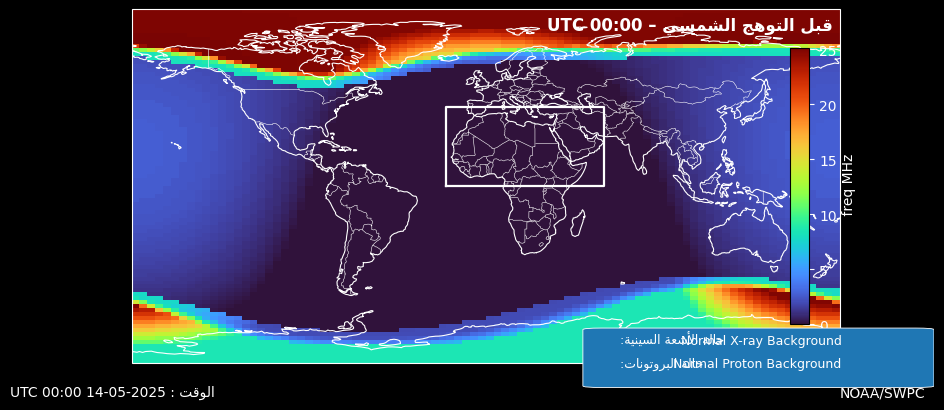

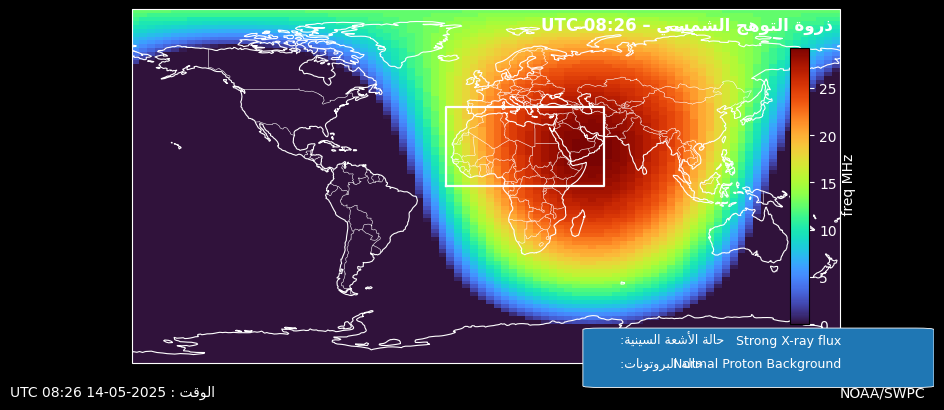

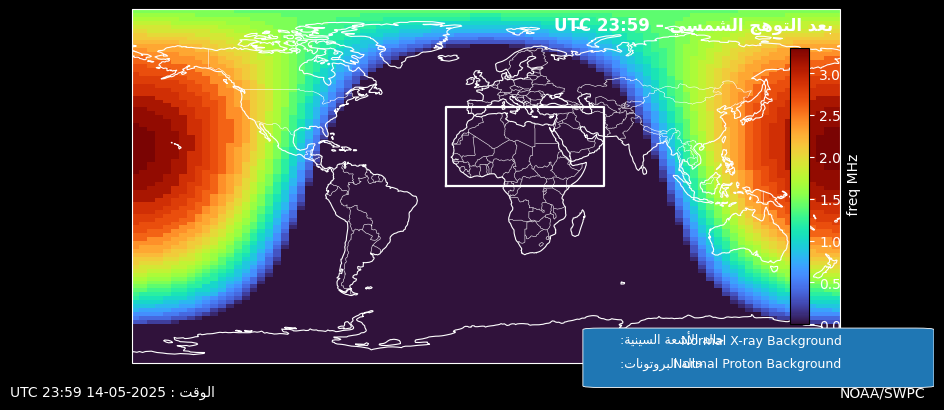

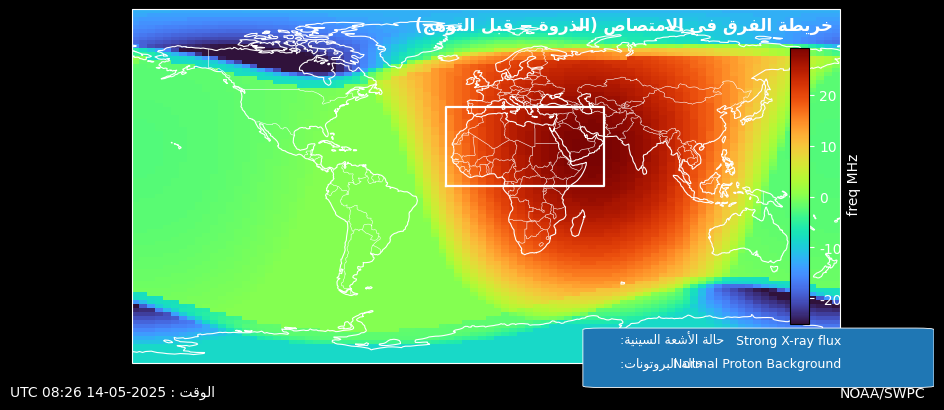

In [108]:

lats_pre, lons_pre, g_pre, meta_pre = records[pre_time]
lats_pk,  lons_pk,  g_pk,  meta_pk  = records[peak_time]
lats_po,  lons_po,  g_po,  meta_po  = records[post_time]

plot_map_noaa_style(lats_pre, lons_pre, g_pre,
                    f"قبل التوهج الشمسي – {pre_time.strftime('%H:%M UTC')}",
                    valid_time=pre_time, meta=meta_pre)

plot_map_noaa_style(lats_pk, lons_pk, g_pk,
                    f"ذروة التوهج الشمسي – {peak_time.strftime('%H:%M UTC')}",
                    valid_time=peak_time, meta=meta_pk)

plot_map_noaa_style(lats_po, lons_po, g_po,
                    f"بعد التوهج الشمسي – {post_time.strftime('%H:%M UTC')}",
                    valid_time=post_time, meta=meta_po)

# خريطة الفرق
diff = g_pk - g_pre
plot_map_noaa_style(lats_pk, lons_pk, diff,
                    "خريطة الفرق في الامتصاص (الذروة − قبل التوهج)",
                    valid_time=peak_time, meta=meta_pk)


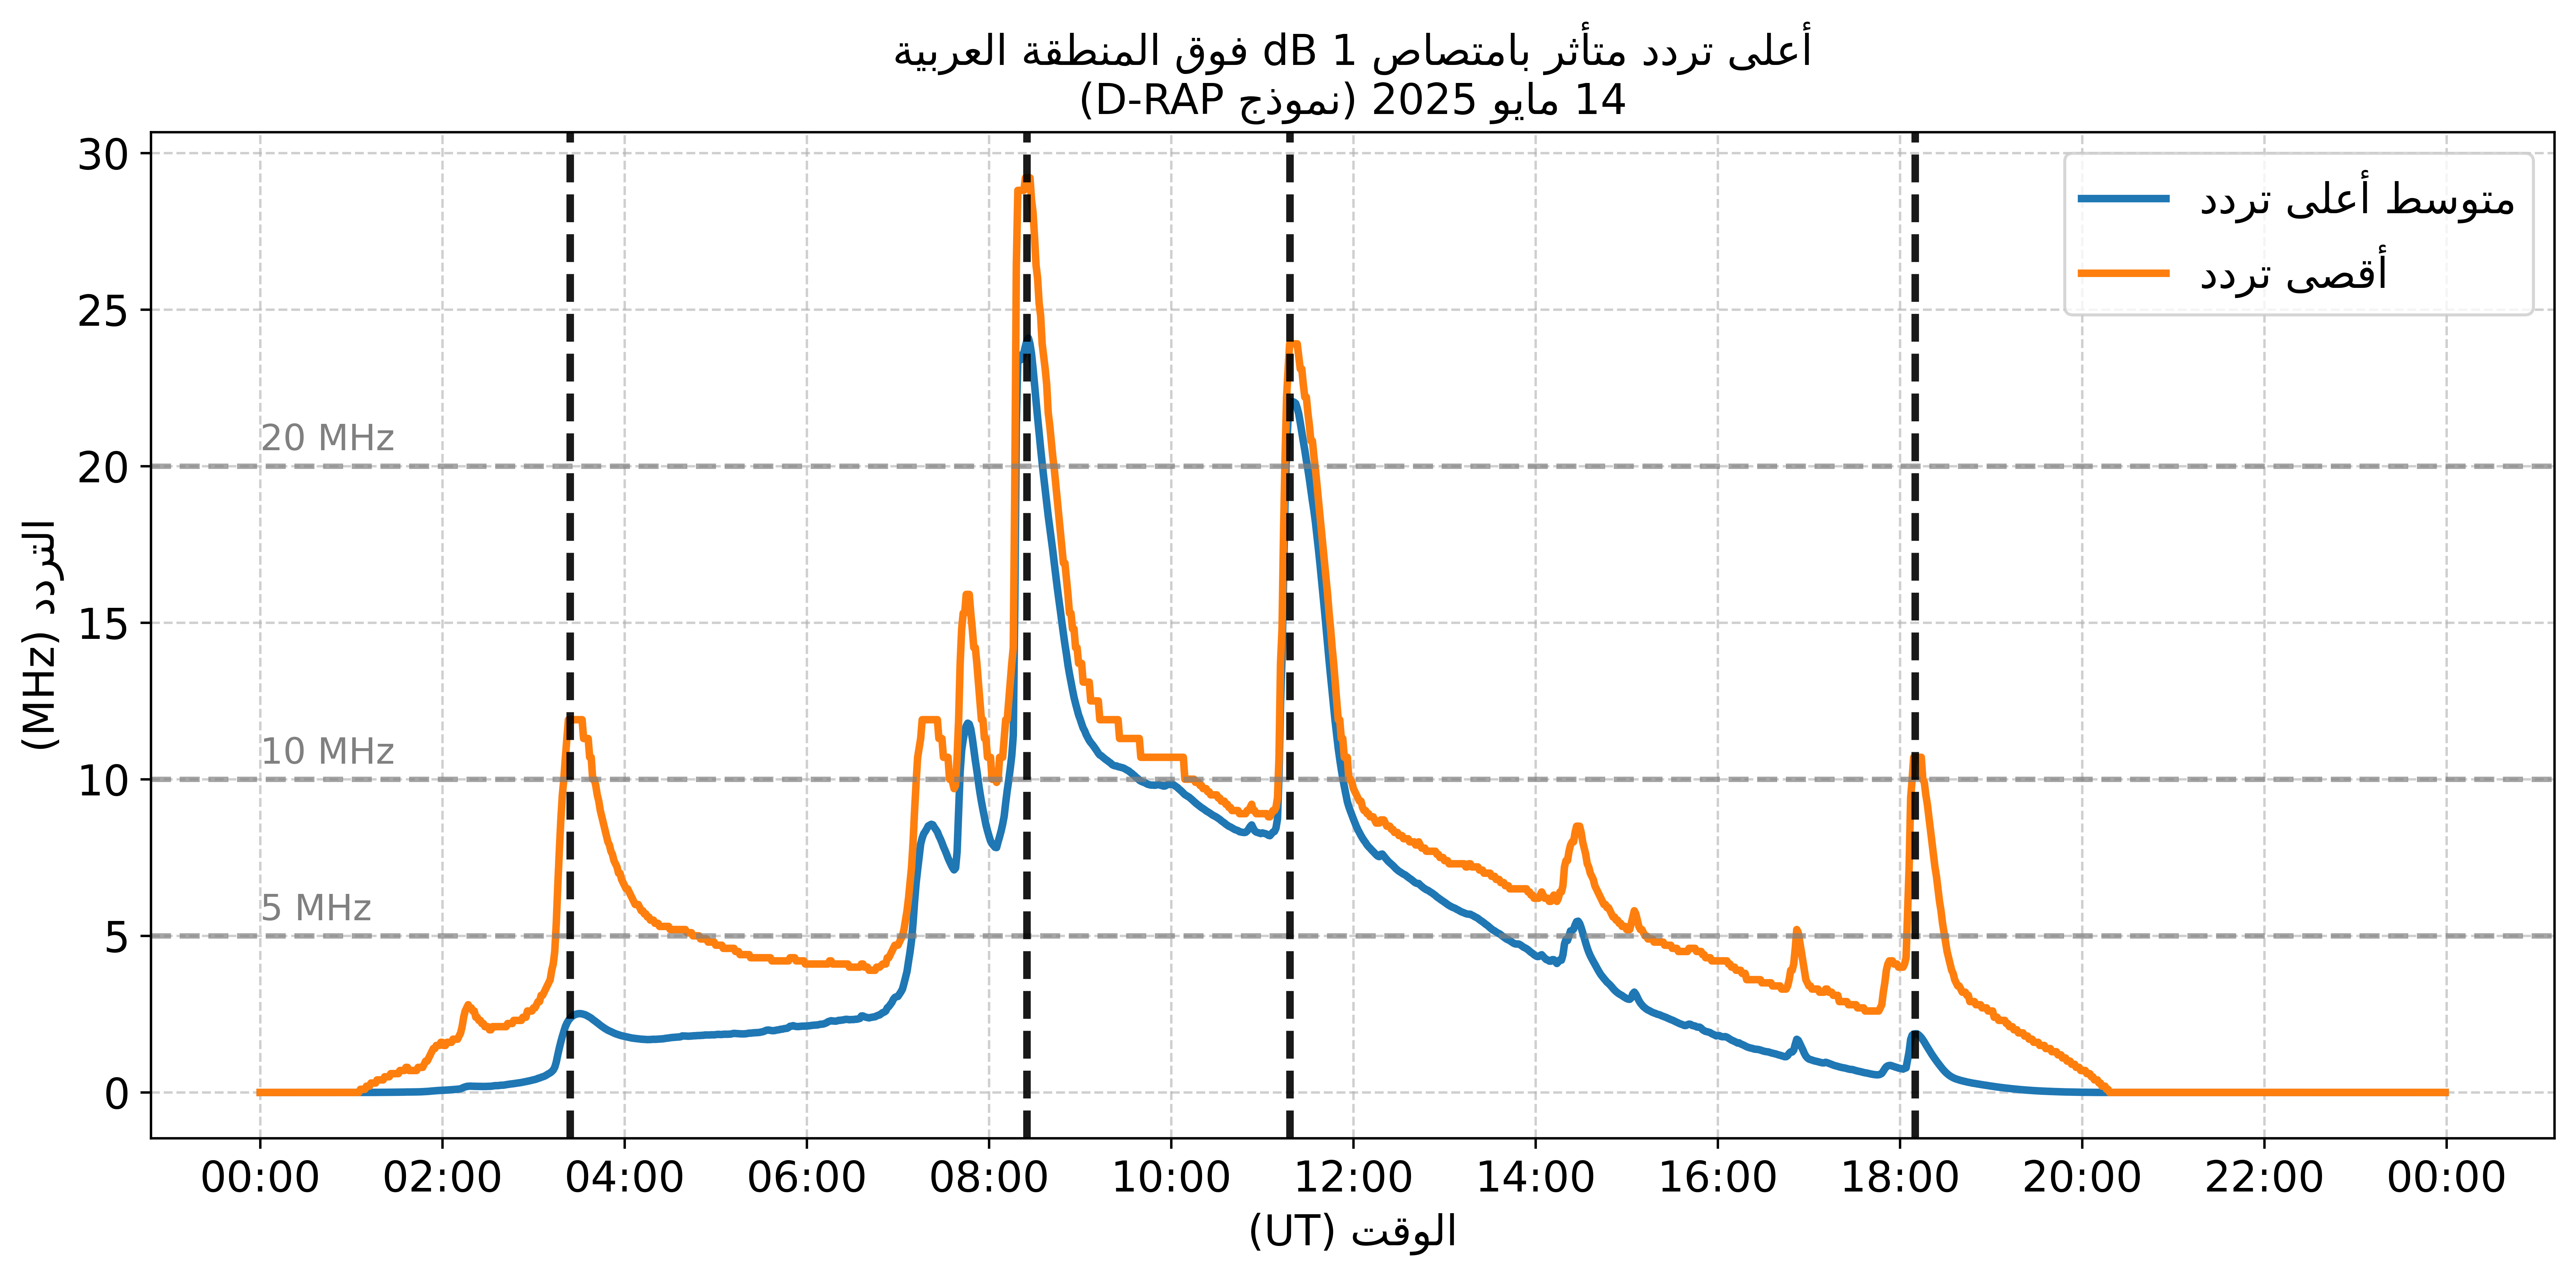

Main MAX-curve peaks (UTC):
Peak 1: 03:24 UTC — HAF@1 dB = 11.90 MHz
Peak 2: 08:25 UTC — HAF@1 dB = 29.20 MHz
Peak 3: 11:18 UTC — HAF@1 dB = 23.90 MHz
Peak 4: 18:10 UTC — HAF@1 dB = 10.70 MHz


In [109]:


plt.figure(figsize=(12, 6), dpi=600)


plt.plot(
    df["time"],
    df["mean"],
    label=ar("متوسط أعلى تردد"),
    linewidth=2.5
)

plt.plot(
    df["time"],
    df["max"],
    label=ar("أقصى تردد"),
    linewidth=2.5
)



FREQ_THRESHOLDS = [5, 10, 20]

for thr in FREQ_THRESHOLDS:
    plt.axhline(
        y=thr,
        color="gray",
        linestyle="--",
        linewidth=1.8,
        alpha=0.7
    )
    plt.text(
        df["time"].iloc[0],
        thr + 0.5,
        f"{thr} MHz",
        fontsize=12,
        color="gray"
    )



df_sorted = df.sort_values("max", ascending=False)

peak_times = []
peak_values = []

MIN_SEPARATION = pd.Timedelta(hours=2.0)
N_PEAKS = 4

for _, row in df_sorted.iterrows():
    t = row["time"]
    if all(abs(t - pt) > MIN_SEPARATION for pt in peak_times):
        peak_times.append(t)
        peak_values.append(row["max"])
    if len(peak_times) == N_PEAKS:
        break

peak_times, peak_values = zip(*sorted(zip(peak_times, peak_values), key=lambda x: x[0]))



for t in peak_times:
    plt.axvline(
        t,
        color="black",
        linestyle="--",
        linewidth=2.5,
        alpha=0.9
    )




ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))

ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)

plt.xlabel(ar("الوقت (UT)"), fontsize=14)
plt.ylabel(ar("التردد (MHz)"), fontsize=14)

plt.title(
    ar("أعلى تردد متأثر بامتصاص 1 dB فوق المنطقة العربية\n"
       "14 مايو 2025 (نموذج D-RAP)"),
    fontsize=14
)

plt.legend(fontsize=14)
plt.grid(True, which="both", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()




print("Main MAX-curve peaks (UTC):")
for i, (t, v) in enumerate(zip(peak_times, peak_values), start=1):
    print(f"Peak {i}: {pd.to_datetime(t).strftime('%H:%M')} UTC — HAF@1 dB = {v:.2f} MHz")


In [110]:
FREQ_THRESHOLDS = [5, 10, 20]  # MHz
df2 = df.copy()
df2["time"] = pd.to_datetime(df2["time"])
df2 = df2.sort_values("time").reset_index(drop=True)

dt_hours = df2["time"].diff().dt.total_seconds().median() / 3600.0

f_mean = df2["mean"].to_numpy()
f_max  = df2["max"].to_numpy()




def intervals_from_bool(time_series, mask):
    time_series = pd.to_datetime(time_series)
    mask = np.asarray(mask, dtype=bool)

    if mask.sum() == 0:
        return []

    idx = np.where(mask)[0]
    splits = np.where(np.diff(idx) > 1)[0] + 1
    groups = np.split(idx, splits)

    intervals = []
    for g in groups:
        start = time_series.iloc[g[0]]
        end   = time_series.iloc[g[-1]]
        intervals.append((start, end))
    return intervals

def duration_hours(mask):
    return float(np.sum(mask) * dt_hours)

def stats(series):
    return {
        "max": float(np.nanmax(series)),
        "mean": float(np.nanmean(series)),
        "integral": float(np.nansum(series) * dt_hours)  # MHz·h
    }



s_mean = stats(f_mean)
s_max  = stats(f_max)

t_peak_mean = df2["time"].iloc[np.nanargmax(f_mean)]
t_peak_max  = df2["time"].iloc[np.nanargmax(f_max)]




print("\n================ HF Impact Summary (D-RAP HFA ≥1 dB) ================\n")

print("Temporal Coverage:")
print(f"  Start: {df2['time'].iloc[0].strftime('%Y-%m-%d %H:%M')} UTC")
print(f"  End  : {df2['time'].iloc[-1].strftime('%Y-%m-%d %H:%M')} UTC")
print(f"  Median cadence: {dt_hours*60:.1f} minutes\n")

print("Peak Penetration:")
print(f"  Maximum HFA (regional max): {s_max['max']:.2f} MHz at {t_peak_max.strftime('%H:%M')} UTC")
print(f"  Maximum HFA (regional mean): {s_mean['max']:.2f} MHz at {t_peak_mean.strftime('%H:%M')} UTC\n")

print("Mean State:")
print(f"  Time-averaged regional mean HFA: {s_mean['mean']:.2f} MHz")
print(f"  Frequency–time exposure (mean curve): {s_mean['integral']:.2f} MHz·h")
print(f"  Frequency–time exposure (max curve) : {s_max['integral']:.2f} MHz·h\n")

print("Duration Above Operational HF Thresholds:")

rows = []

for thr in FREQ_THRESHOLDS:
    mask_mean = f_mean >= thr
    mask_max  = f_max  >= thr

    dur_mean = duration_hours(mask_mean)
    dur_max  = duration_hours(mask_max)

    print(f"  ≥ {thr:2d} MHz:")
    print(f"      Mean curve duration: {dur_mean:.2f} h")
    print(f"      Max  curve duration: {dur_max:.2f} h")

    rows.append([thr, dur_mean, dur_max])

print("\n======================================================================\n")



summary_table = pd.DataFrame(
    rows,
    columns=["Frequency Threshold (MHz)",
             "Duration above threshold – Mean curve (h)",
             "Duration above threshold – Max curve (h)"]
)

display(summary_table)



================ HF Impact Summary (D-RAP HFA ≥1 dB) ================

Temporal Coverage:
  Start: 2025-05-14 00:00 UTC
  End  : 2025-05-14 23:59 UTC
  Median cadence: 1.0 minutes

Peak Penetration:
  Maximum HFA (regional max): 29.20 MHz at 08:24 UTC
  Maximum HFA (regional mean): 24.08 MHz at 08:26 UTC

Mean State:
  Time-averaged regional mean HFA: 3.69 MHz
  Frequency–time exposure (mean curve): 87.23 MHz·h
  Frequency–time exposure (max curve) : 131.50 MHz·h

Duration Above Operational HF Thresholds:
  ≥  5 MHz:
      Mean curve duration: 6.58 h
      Max  curve duration: 10.15 h
  ≥ 10 MHz:
      Mean curve duration: 2.33 h
      Max  curve duration: 4.23 h
  ≥ 20 MHz:
      Mean curve duration: 0.53 h
      Max  curve duration: 0.75 h




,Frequency Threshold (MHz),Duration above threshold – Mean curve (h),Duration above threshold – Max curve (h)
0,5,6.583333,10.150000
1,10,2.333333,4.233333
2,20,0.533333,0.750000


In [111]:

THRESHOLDS_MHZ = [5, 10, 20]

for thr in THRESHOLDS_MHZ:
    colname = f"frac_area_gt_{thr:.0f}mhz"
    if colname not in df.columns:
        df[colname] = np.nan

for i, row in df.iterrows():
    t = row["time"]

    lats, lons, grid, _meta = records[t]
    agrid = subset_region(lats, lons, grid)

    valid = np.isfinite(agrid)
    total_cells = valid.sum()

    if total_cells == 0:
        continue

    for thr in THRESHOLDS_MHZ:
        affected = valid & (agrid >= thr)
        df.loc[i, f"frac_area_gt_{thr:.0f}mhz"] = affected.sum() / total_cells


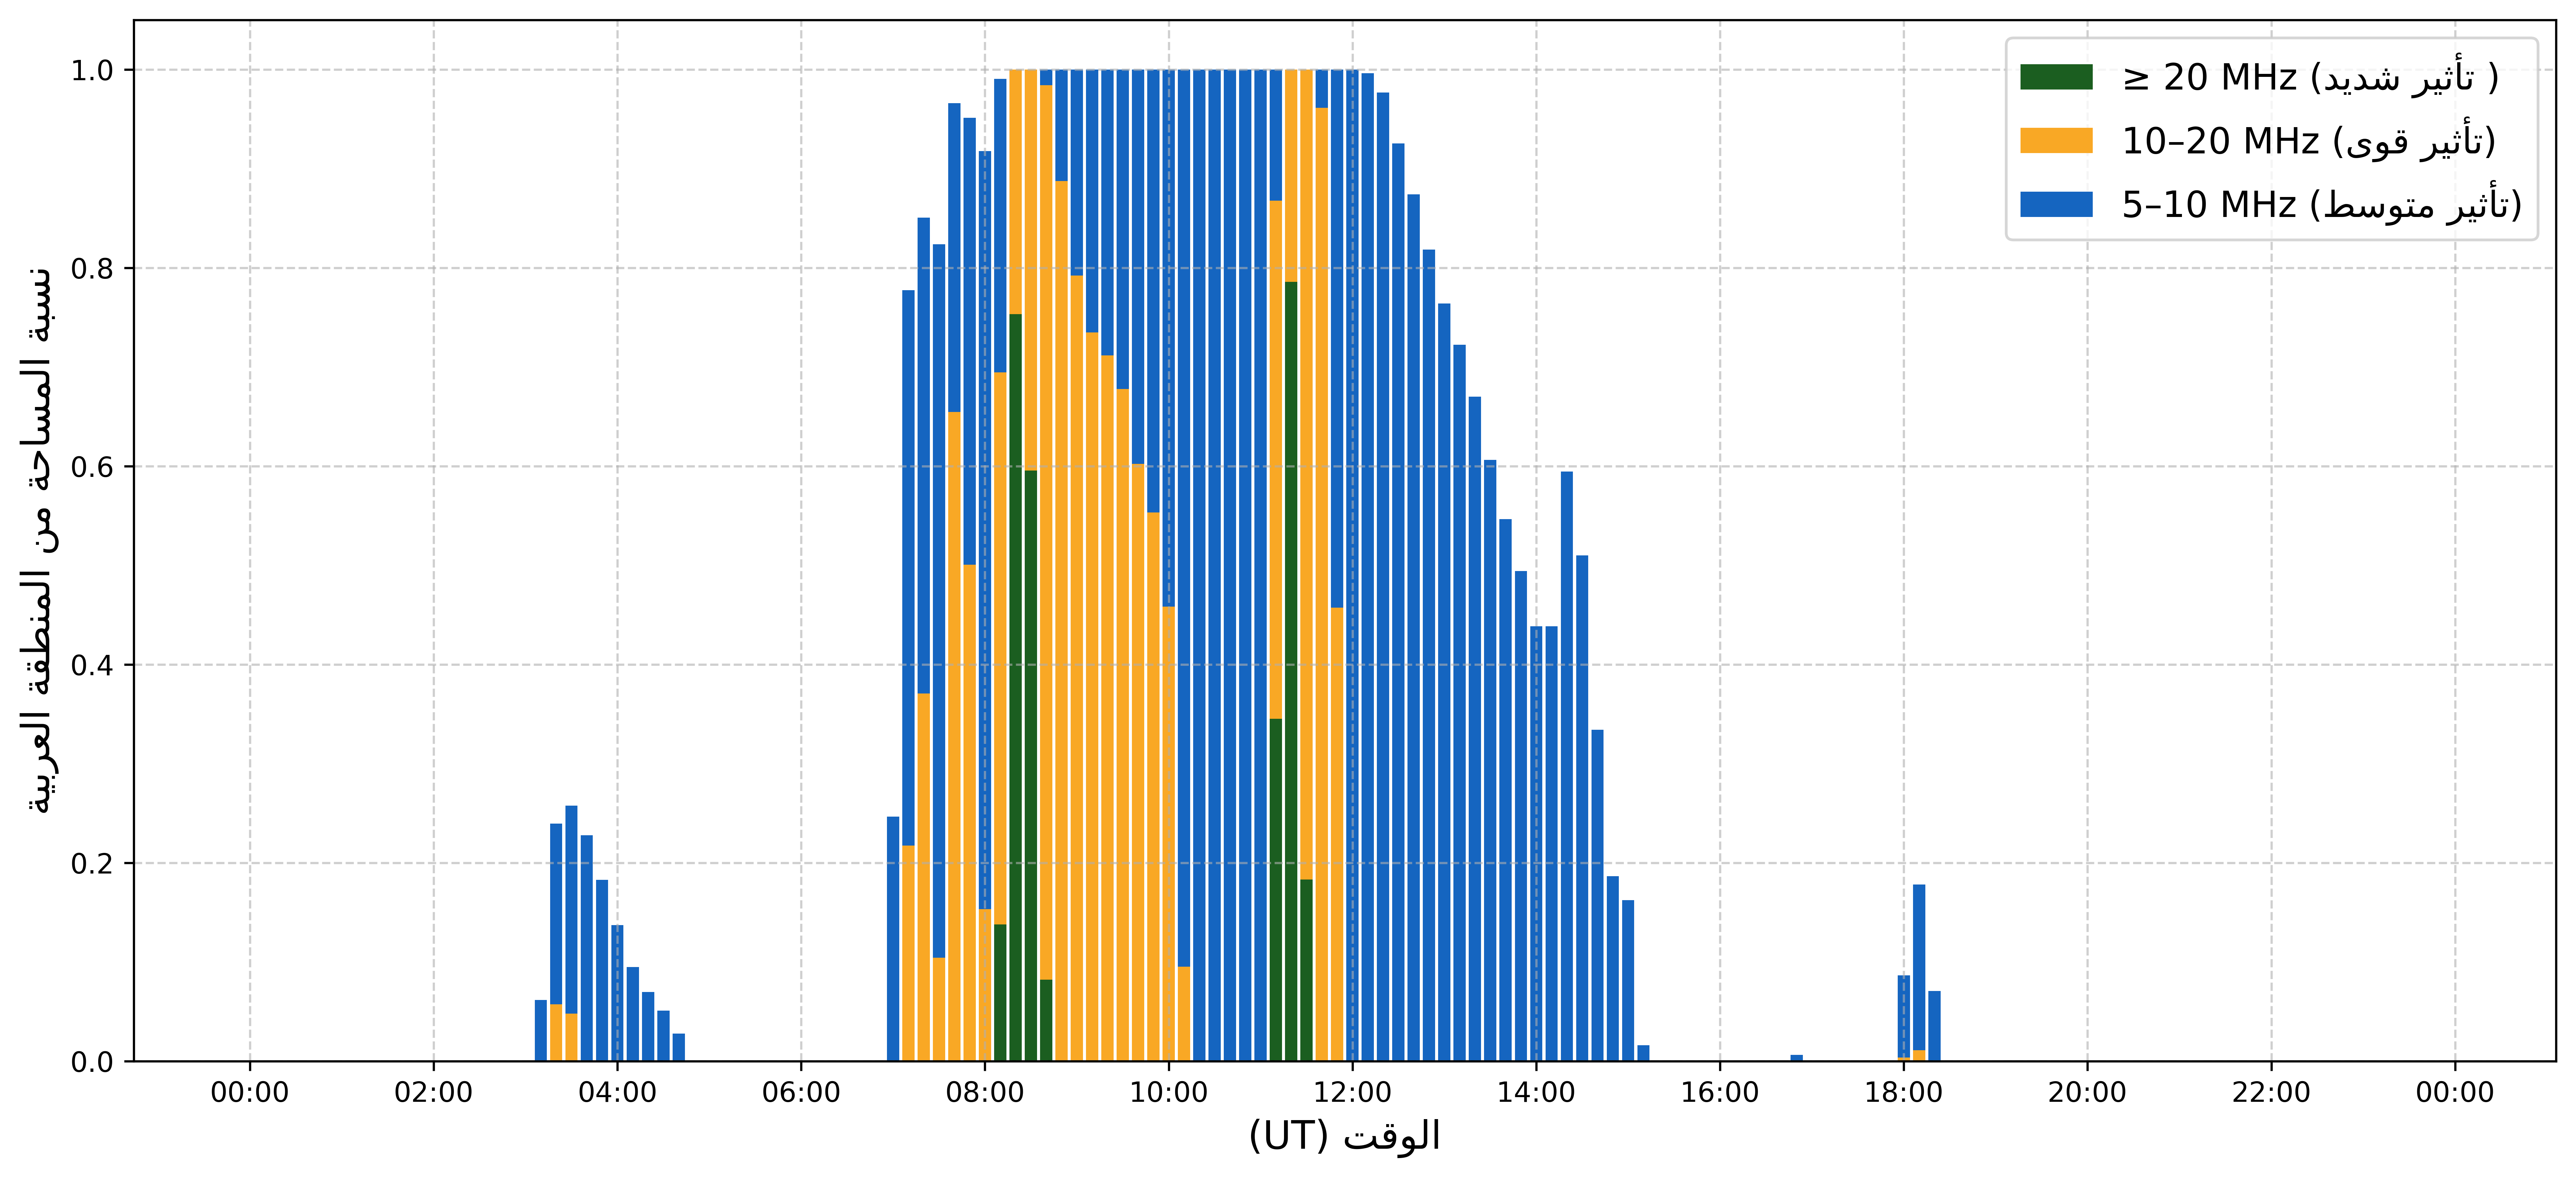

In [112]:
df_bar = df.set_index("time").resample("10min").mean().reset_index()




thr_low  = 5
thr_mid  = 10
thr_high = 20

area_low  = df_bar[f"frac_area_gt_{thr_low:.0f}mhz"].values
area_mid  = df_bar[f"frac_area_gt_{thr_mid:.0f}mhz"].values
area_high = df_bar[f"frac_area_gt_{thr_high:.0f}mhz"].values



layer_high = area_high
layer_mid  = area_mid - area_high
layer_low  = area_low - area_mid

# تأكد من عدم وجود قيم سالبة بسبب ضوضاء عددية
layer_mid = np.clip(layer_mid, 0, None)
layer_low = np.clip(layer_low, 0, None)




plt.figure(figsize=(13,6), dpi=600)

bar_width = 8/1440  # عرض ~8 دقائق بوحدة اليوم

plt.bar(df_bar["time"], layer_high,
        width=bar_width,
        color="#1B5E20",
        #label=ar("≥ 20 MHz (اختراق شديد للنطاق العالي)"))
        label=ar("≥ 20 MHz (تأثير شديد )"))

plt.bar(df_bar["time"], layer_mid,
        width=bar_width,
        bottom=layer_high,
        color="#F9A825",
        label=ar("10–20 MHz (تأثير قوى)"))

plt.bar(df_bar["time"], layer_low,
        width=bar_width,
        bottom=layer_high + layer_mid,
        color="#1565C0",
        label=ar("5–10 MHz (تأثير متوسط)"))

plt.xlabel(ar("الوقت (UT)"), fontsize=14)
plt.ylabel(ar("نسبة المساحة من المنطقة العربية"), fontsize=14)

plt.ylim(0,1.05)
plt.grid(axis="y", linestyle="--", alpha=0.4)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))

plt.grid(True, which="both", linestyle="--", alpha=0.6)

plt.legend(fontsize=13, loc="upper right")
plt.tight_layout()
plt.show()


In [113]:
import numpy as np
import pandas as pd


COMPLETE_FRAC = 0.99

df2 = df.copy()
df2["time"] = pd.to_datetime(df2["time"])
df2 = df2.sort_values("time").reset_index(drop=True)

dt_hours = df2["time"].diff().dt.total_seconds().median() / 3600.0


col_5  = "frac_area_gt_5mhz"
col_10 = "frac_area_gt_10mhz"
col_20 = "frac_area_gt_20mhz"

a5  = df2[col_5].to_numpy()
a10 = df2[col_10].to_numpy()
a20 = df2[col_20].to_numpy()




def intervals_from_bool(t, mask):
    mask = np.asarray(mask, dtype=bool)
    if mask.sum() == 0:
        return []

    idx = np.where(mask)[0]
    splits = np.where(np.diff(idx) > 1)[0] + 1
    groups = np.split(idx, splits)

    intervals = []
    for g in groups:
        intervals.append((t.iloc[g[0]], t.iloc[g[-1]]))
    return intervals

def duration_hours(mask):
    return float(np.sum(mask) * dt_hours)

def stats(series):
    return {
        "max": float(np.nanmax(series)),
        "mean": float(np.nanmean(series)),
        "integral": float(np.nansum(series) * dt_hours)
    }



# Any-coverage masks
m5  = a5  > 0
m10 = a10 > 0
m20 = a20 > 0



# Complete coverage masks
c5  = a5  >= COMPLETE_FRAC
c10 = a10 >= COMPLETE_FRAC
c20 = a20 >= COMPLETE_FRAC




# Statistics
s5  = stats(a5)
s10 = stats(a10)
s20 = stats(a20)

tmax_5  = df2["time"].iloc[np.nanargmax(a5)]
tmax_10 = df2["time"].iloc[np.nanargmax(a10)]
tmax_20 = df2["time"].iloc[np.nanargmax(a20)]





print("\n================ Arabian Region HF Penetration Summary (D-RAP) ================")
print(f"Date: {df2['time'].iloc[0].strftime('%Y-%m-%d')} (UTC)")
print(f"Cadence: {dt_hours*60:.1f} minutes\n")

print("---- Total duration of penetration (any coverage) ----")
print(f"> 5 MHz  : {duration_hours(m5):6.2f} h")
print(f">10 MHz  : {duration_hours(m10):6.2f} h")
print(f">20 MHz  : {duration_hours(m20):6.2f} h\n")

print("---- Complete regional penetration (≥99% area) ----")
print(f"> 5 MHz  : {duration_hours(c5):6.2f} h")
print(f">10 MHz  : {duration_hours(c10):6.2f} h")
print(f">20 MHz  : {duration_hours(c20):6.2f} h\n")

print("---- Peak regional coverage ----")
print(f"> 5 MHz  : max={s5['max']:.3f} at {tmax_5.strftime('%H:%M')} UTC")
print(f">10 MHz  : max={s10['max']:.3f} at {tmax_10.strftime('%H:%M')} UTC")
print(f">20 MHz  : max={s20['max']:.3f} at {tmax_20.strftime('%H:%M')} UTC\n")

print("---- Integrated exposure (area–time, frac·h) ----")
print(f"> 5 MHz  : {s5['integral']:.2f}")
print(f">10 MHz  : {s10['integral']:.2f}")
print(f">20 MHz  : {s20['integral']:.2f}")
print("===============================================================================")





summary_df = pd.DataFrame([
    ["5 MHz",  duration_hours(m5),  duration_hours(c5),  s5["max"],  tmax_5,  s5["mean"],  s5["integral"]],
    ["10 MHz", duration_hours(m10), duration_hours(c10), s10["max"], tmax_10, s10["mean"], s10["integral"]],
    ["20 MHz", duration_hours(m20), duration_hours(c20), s20["max"], tmax_20, s20["mean"], s20["integral"]],
], columns=[
    "Threshold",
    "Duration_any (h)",
    "Duration_complete (h)",
    "Max_fraction",
    "Time_of_max (UTC)",
    "Mean_fraction",
    "Area_time_integral (frac·h)"
])

display(summary_df)



================ Arabian Region HF Penetration Summary (D-RAP) ================
Date: 2025-05-14 (UTC)
Cadence: 1.0 minutes

---- Total duration of penetration (any coverage) ----
> 5 MHz  :  10.15 h
>10 MHz  :   4.23 h
>20 MHz  :   0.75 h

---- Complete regional penetration (≥99% area) ----
> 5 MHz  :   4.15 h
>10 MHz  :   1.02 h
>20 MHz  :   0.00 h

---- Peak regional coverage ----
> 5 MHz  : max=1.000 at 08:16 UTC
>10 MHz  : max=1.000 at 08:19 UTC
>20 MHz  : max=0.860 at 11:19 UTC

---- Integrated exposure (area–time, frac·h) ----
> 5 MHz  : 7.01
>10 MHz  : 2.59
>20 MHz  : 0.48


,Threshold,Duration_any (h),Duration_complete (h),Max_fraction,Time_of_max (UTC),Mean_fraction,Area_time_integral (frac·h)
0,5 MHz,10.150000,4.150000,1.00,2025-05-14 08:16:00+00:00,0.296436,7.010708
1,10 MHz,4.233333,1.016667,1.00,2025-05-14 08:19:00+00:00,0.109533,2.590458
2,20 MHz,0.750000,0.000000,0.86,2025-05-14 11:19:00+00:00,0.020322,0.480625
